# tSNE for events and exploration of tSNE parameters

''' Created on Tue 04 Aug 2020'''


In this notebook we will analyze periods of exploratory behaviour without taking into account the object that is being explore. We will take the first 6 seconds of exploration (because we are currently using a re sampling of 20 frames that gives us 2s bins, just to use a multipler), if posible some segment in the middle and the resting periods.

We will explore the impact of the perplexity parameter and number of iterations of tSNE rutine.

And also, we will use the tSNE rutine for raw data and for correlation matrix data. The idea is to study the underling structure of traces in time and also of neural correlations. For both cases we will do a paramenter exploration for tSNE.

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
from sklearn.manifold import TSNE
cmap = cm.jet

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165          ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                ## value of resampling

session_now = 4
period = 6
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
#define directory if current data and directory for analyzed data
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/tSNE_analysis/'

In [4]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [5]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf

In [6]:
# define exploration, resting and navigation events from the behavioural vector
events_list = []
events_counter_list = []
events_time_starts = []
start_counter = 100
counter = 0
for i in range(resample_beh1.shape[0]):
    if resample_beh1[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        events_time_starts.append(i)
        start_counter = resample_beh1[i]
        counter = 1
    else:
        counter = counter + 1

In [7]:
# assign corresponding calcium traces from the previously defined events to different activity lists.
events = np.array(events_list)
events_counter = np.array(events_counter_list)
events_time = np.array(events_time_starts)

#resting periods
resting_activity = []
target = 0
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]   # convert to seconds
time = events_time[position_events]
i = 0
for event in events_duration:
    if event > period:
        resting_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i + 1

#non-exploring or navigation periods
nonexploring_activity = []
target = 1
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]
time = events_time[position_events]
i = 0
for event in events_duration:
    if event > period:
        nonexploring_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i+1

#object exploration periods
exploring_activity = []
for target in [2,3,4,5]:
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]
    time = events_time[position_events]
    i = 0
    for event in events_duration:
        if event > period:
            exploring_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i+1

In [8]:
### sorted by mean firing rate RESTING
mean_over_trials = np.mean(resting_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_r = np.flip(np.argsort(mean_firing_rate))
resting = mean_over_trials[positions_r,:]
non_zero_positions_r = np.where(np.mean(resting,axis=1))
resting_non_zero = resting[non_zero_positions_r,:]
resting_non_zero = resting_non_zero[0,:,:]

positions1 = positions_r[np.where(mean_firing_rate[positions_r])]
resting_corr_matrix2 = stats.corr_matrix(neural_activity = resting_non_zero)

resting_matrix = np.zeros((positions1.shape[0],period*len(resting_activity)))
for i in range(len(resting_activity)):
    resting_matrix[:,i*period:(i+1)*period] = resting_activity[i][positions1,:] - mean_over_trials[positions1,:]
resting_corr_matrix = stats.corr_matrix(neural_activity = resting_matrix)

<Figure size 432x288 with 0 Axes>

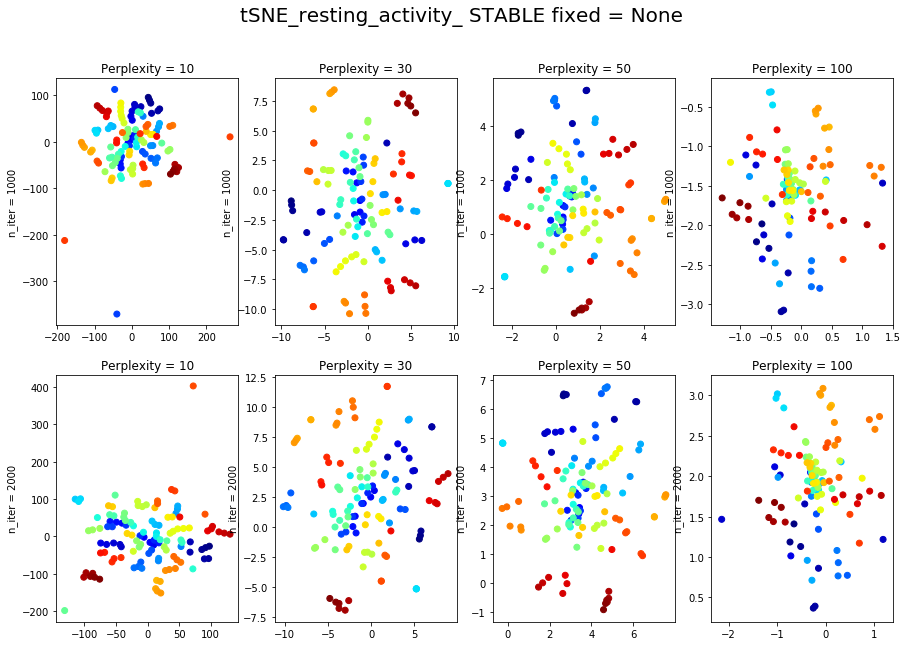

In [9]:
n_components = 2
fig = plt.figure()

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        resting_embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(resting_matrix.T)
        color1 = np.linspace(0, 20, resting_embedded.shape[0])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_resting_activity_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_resting_activity_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

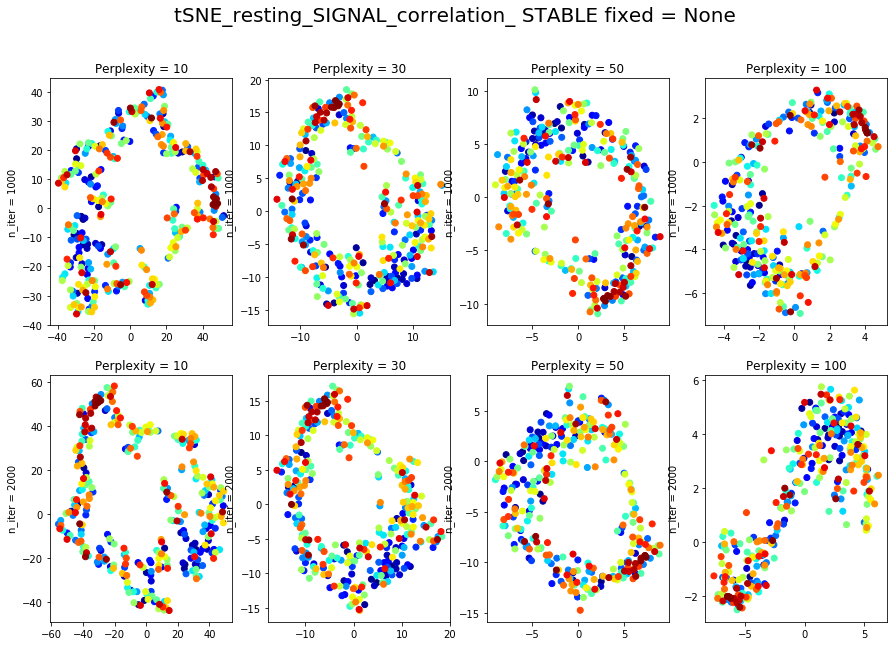

In [10]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        resting_embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(resting_corr_matrix2.T)
        color1 = np.linspace(0, 20, resting_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_resting_SIGNAL_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_resting_SIGNAL_correlation_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

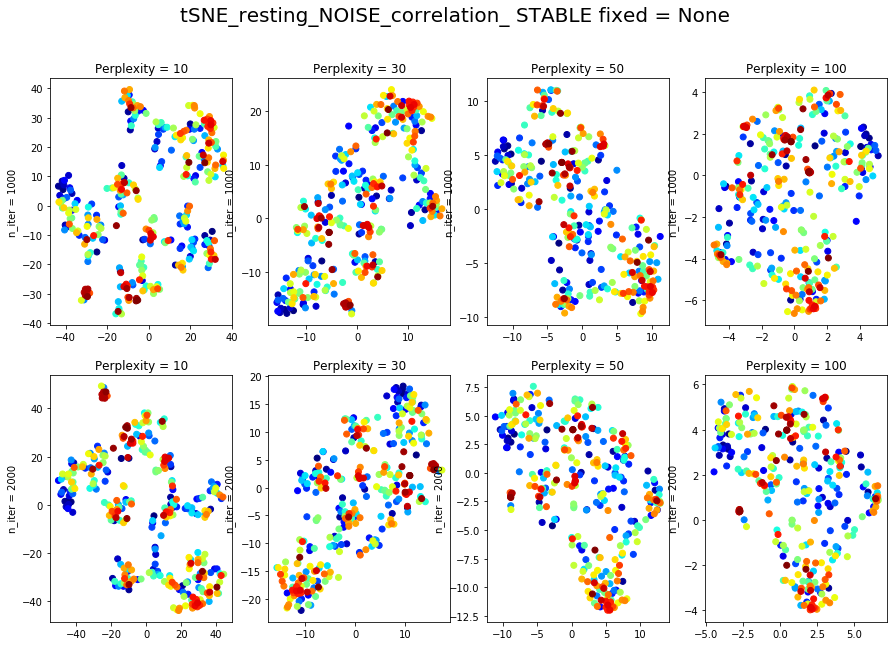

In [11]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        resting_embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(resting_corr_matrix.T)
        color1 = np.linspace(0, 20, resting_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_resting_NOISE_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_resting_NOISE_correlation_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [12]:
### sorted by position in segment

mean_over_trials = np.mean(resting_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_r = np.flip(np.argsort(mean_firing_rate))
resting = mean_over_trials[positions_r,:]
non_zero_positions_r = np.where(np.mean(resting,axis=1))
resting_non_zero = resting[non_zero_positions_r,:]
resting_non_zero = resting_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(resting_non_zero,axis=1))
resting_non_zero = resting_non_zero[time_sort,:]

positions1 = positions_r[np.where(mean_firing_rate[positions_r])]
resting_corr_matrix2 = stats.corr_matrix(neural_activity = resting_non_zero)

resting_matrix = np.zeros((positions1.shape[0],period*len(resting_activity)))
for i in range(len(resting_activity)):
    resting_matrix[:,i*period:(i+1)*period] = resting_activity[i][positions_r[time_sort],:]
resting_corr_matrix = stats.corr_matrix(neural_activity = resting_matrix)


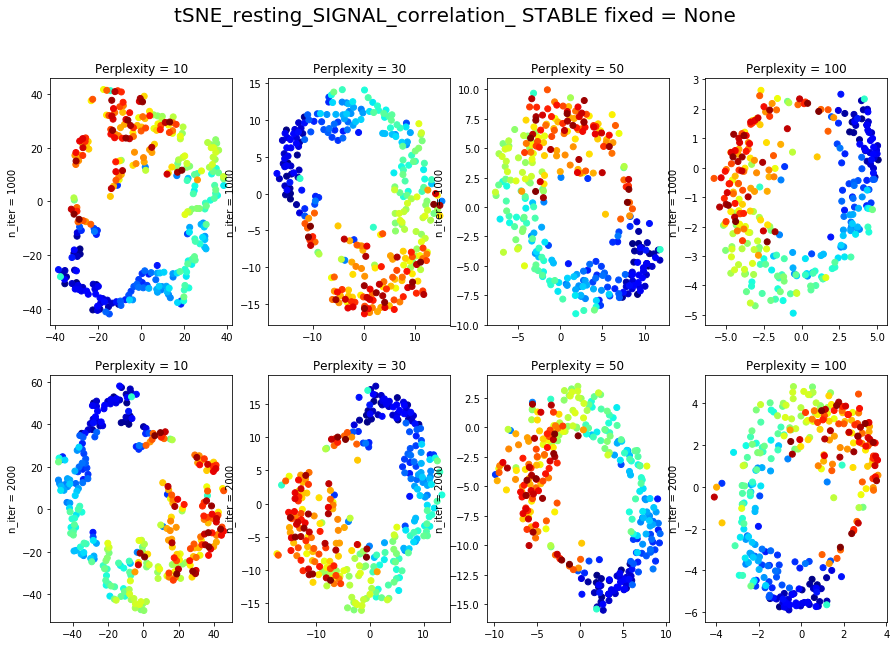

In [13]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        resting_embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(resting_corr_matrix2.T)
        color1 = np.linspace(0, 20, resting_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_resting_SIGNAL_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_resting_SIGNAL_correlation_parameters_time_sorted'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

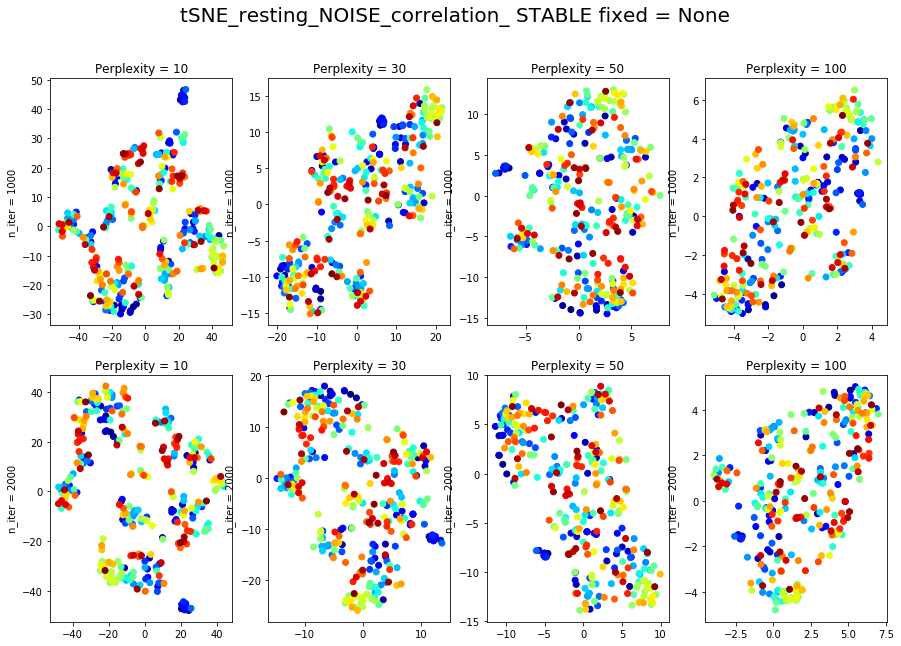

In [14]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        resting_embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(resting_corr_matrix.T)
        color1 = np.linspace(0, 20, resting_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_resting_NOISE_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_resting_NOISE_correlation_parameters_time_sorted'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [15]:
## sorted by mean firing rate NON-EXPLORING OR NAVIGATION
mean_over_trials = np.mean(nonexploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_ne = np.flip(np.argsort(mean_firing_rate))
nonexploring = mean_over_trials[positions_ne,:]
non_zero_positions_ne = np.where(np.mean(nonexploring,axis=1))
nonexploring_non_zero = nonexploring[non_zero_positions_ne,:]
nonexploring_non_zero = nonexploring_non_zero[0,:,:]


positions2= positions_ne[np.where(mean_firing_rate[positions_ne])]
nonexploring_corr_matrix2 = stats.corr_matrix(neural_activity = nonexploring_non_zero)  

nonexploring_matrix= np.zeros((positions2.shape[0],period*len(nonexploring_activity)))
for i in range(len(nonexploring_activity)):
    nonexploring_matrix[:,i*period:(i+1)*period] = nonexploring_activity[i][positions2,:]- mean_over_trials[positions2,:]
nonexploring_corr_matrix= stats.corr_matrix(neural_activity = nonexploring_matrix)


<Figure size 432x288 with 0 Axes>

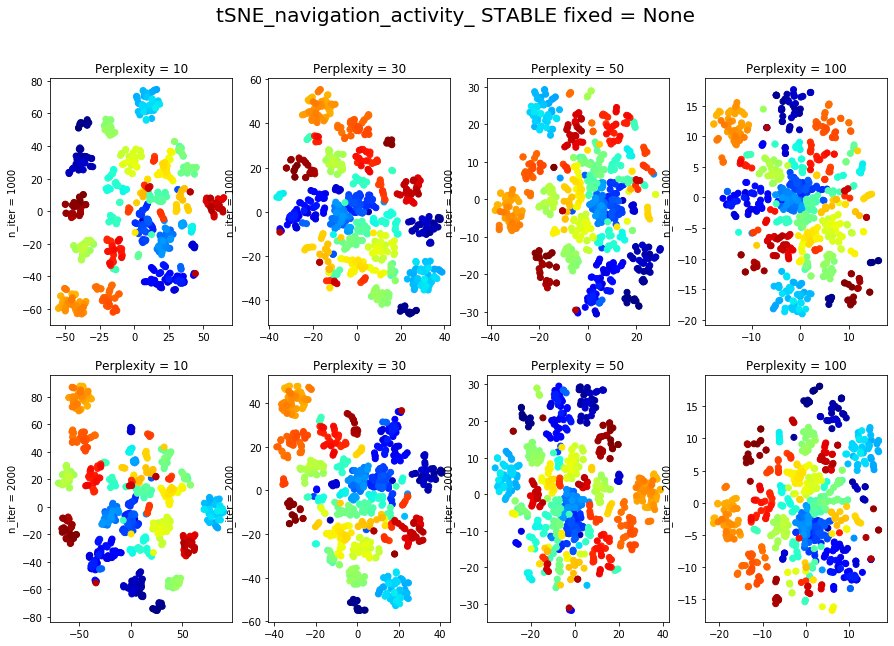

In [16]:
n_components = 2
fig = plt.figure()

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_matrix.T)
        color1 = np.linspace(0, 20, embedded.shape[0])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_activity_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_activity_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

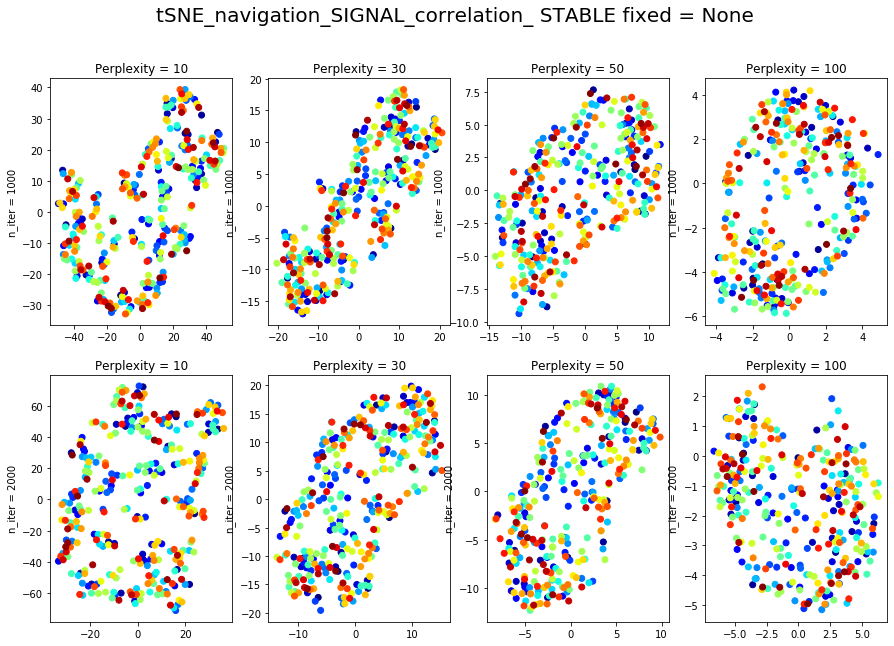

In [17]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_corr_matrix2.T)
        color1 = np.linspace(0, 20, nonexploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_SIGNAL_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_SIGNAL_correlation_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

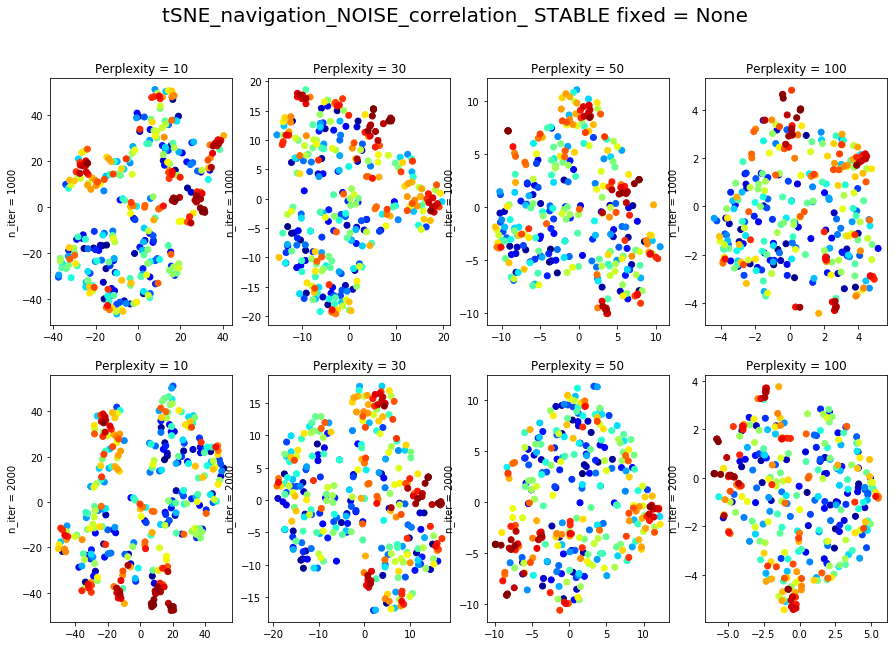

In [18]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_corr_matrix.T)
        color1 = np.linspace(0, 20, nonexploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_NOISE_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_NOISE_correlation_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [19]:
## sorted by temporal position of the max activity

mean_over_trials = np.mean(nonexploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_ne = np.flip(np.argsort(mean_firing_rate))
nonexploring = mean_over_trials[positions_ne,:]
non_zero_positions_ne = np.where(np.mean(nonexploring,axis=1))
nonexploring_non_zero = nonexploring[non_zero_positions_ne,:]
nonexploring_non_zero = nonexploring_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(nonexploring_non_zero,axis=1))
nonexploring_non_zero = nonexploring_non_zero[time_sort,:]


positions2= positions_ne[np.where(mean_firing_rate[positions_ne])]
nonexploring_corr_matrix2 = stats.corr_matrix(neural_activity = nonexploring_non_zero)  

nonexploring_matrix= np.zeros((positions2.shape[0],period*len(nonexploring_activity)))
for i in range(len(nonexploring_activity)):
    nonexploring_matrix[:,i*period:(i+1)*period] = nonexploring_activity[i][positions_ne[time_sort],:]
nonexploring_corr_matrix= stats.corr_matrix(neural_activity = nonexploring_matrix)


<Figure size 432x288 with 0 Axes>

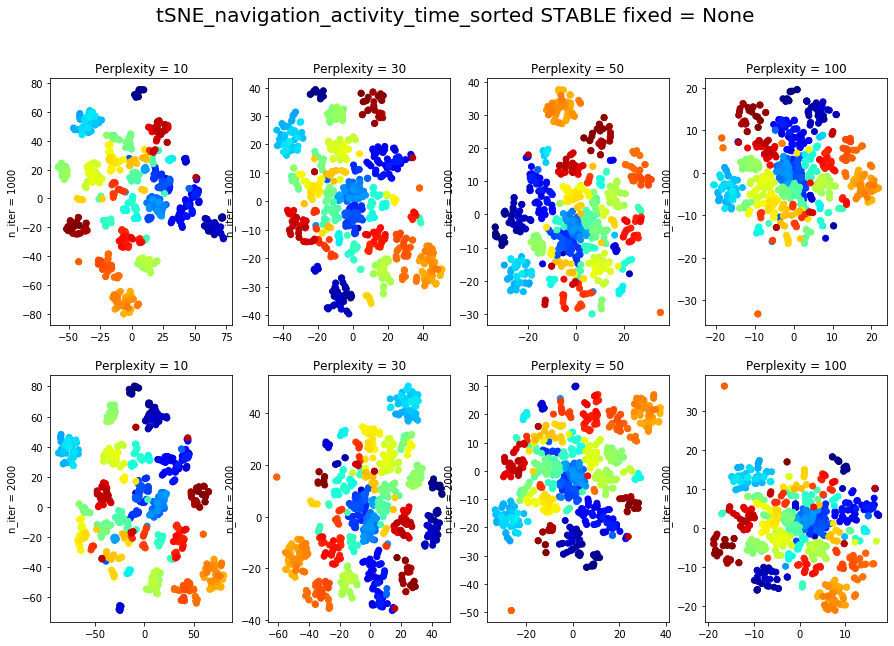

In [20]:
n_components = 2
fig = plt.figure()

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_matrix.T)
        color1 = np.linspace(0, 20, embedded.shape[0])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_activity_time_sorted ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_activity_parameters_time_sorted'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

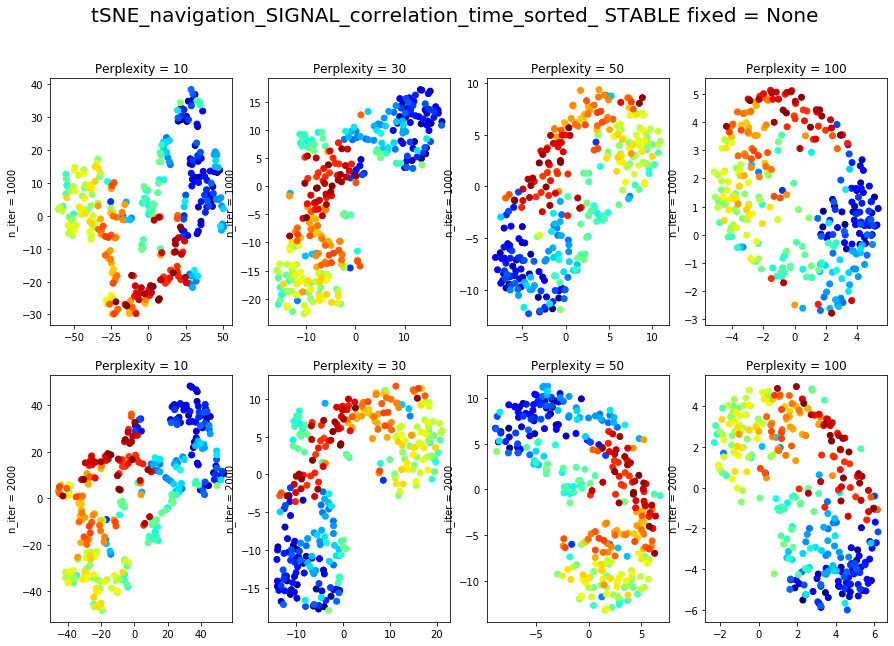

In [21]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_corr_matrix2.T)
        color1 = np.linspace(0, 20, nonexploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_SIGNAL_correlation_time_sorted_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_SIGNAL_correlation_parameters_time_sorted_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

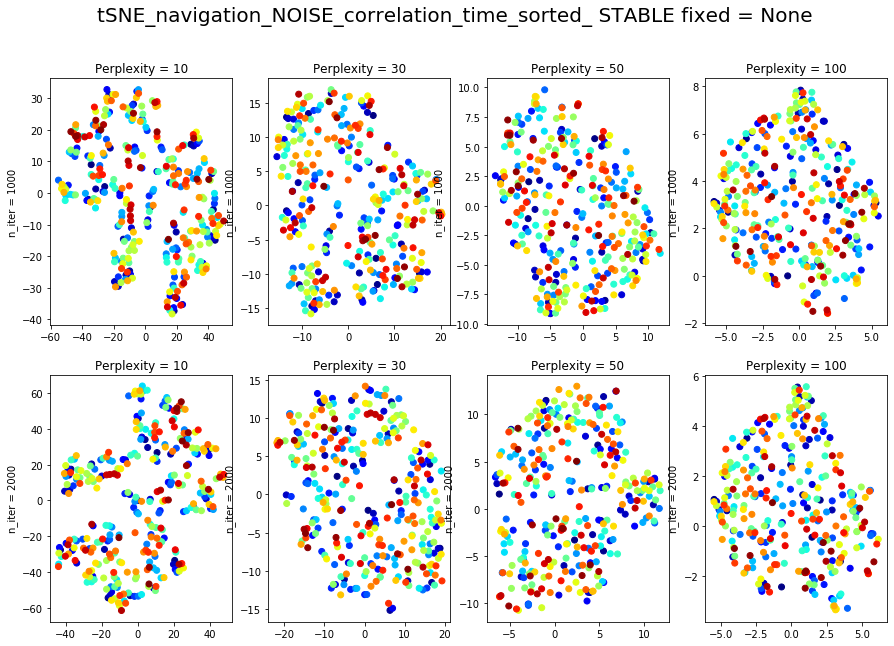

In [22]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(nonexploring_corr_matrix.T)
        color1 = np.linspace(0, 20, nonexploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_navigation_NOISE_correlation_time_sorted_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_navigation_NOISE_correlation_parameters_time_sorted_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [23]:
### exploring matrix (object exploration)

mean_over_trials = np.mean(exploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_e = np.flip(np.argsort(mean_firing_rate))
exploring = mean_over_trials[positions_e,:]
non_zero_positions_e = np.where(np.mean(exploring,axis=1))
exploring_non_zero = exploring[non_zero_positions_e,:]
exploring_non_zero = exploring_non_zero[0,:,:]


positions3 = positions_e[np.where(mean_firing_rate[positions_e])]
exploring_corr_matrix2 = stats.corr_matrix(neural_activity = exploring_non_zero)  

exploring_matrix= np.zeros((positions3.shape[0],period*len(exploring_activity)))
for i in range(len(exploring_activity)):
    exploring_matrix[:,i*period:(i+1)*period] = exploring_activity[i][positions3,:]- mean_over_trials[positions3,:]
exploring_corr_matrix = stats.corr_matrix(neural_activity = exploring_matrix)


<Figure size 432x288 with 0 Axes>

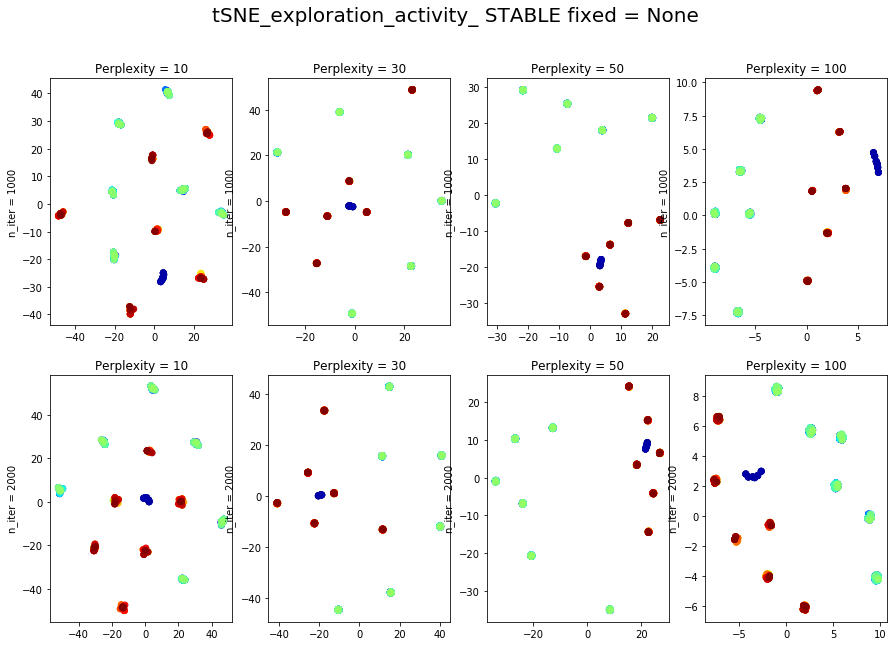

In [24]:
n_components = 2
fig = plt.figure()

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_matrix.T)
        color1 = np.linspace(0, 20, embedded.shape[0])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_activity_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_activity_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

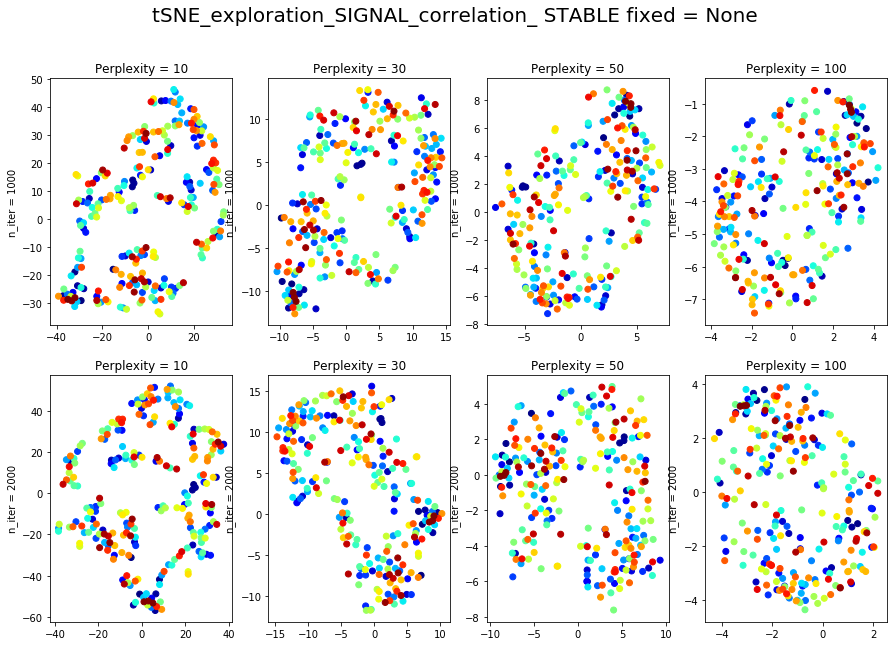

In [25]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_corr_matrix2.T)
        color1 = np.linspace(0, 20, exploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_SIGNAL_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_SIGNAL_correlation_parameters'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

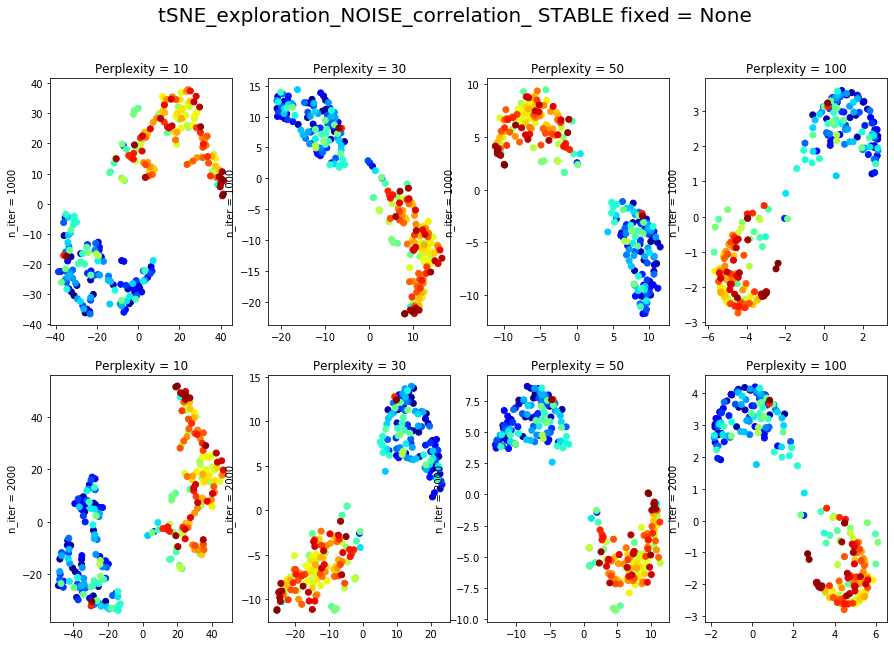

In [26]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_corr_matrix.T)
        color1 = np.linspace(0, 20, exploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_NOISE_correlation_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_NOISE_correlation_parameters_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [27]:
### exploration events SORTED by time max position

mean_over_trials = np.mean(exploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_e = np.flip(np.argsort(mean_firing_rate))
exploring = mean_over_trials[positions_e,:]
non_zero_positions_e = np.where(np.mean(exploring,axis=1))
exploring_non_zero = exploring[non_zero_positions_e,:]
exploring_non_zero = exploring_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(exploring_non_zero,axis=1))
exploring_non_zero = exploring_non_zero[time_sort,:]


positions3 = positions_e[np.where(mean_firing_rate[positions_e])]
exploring_corr_matrix2 = stats.corr_matrix(neural_activity = exploring_non_zero)  

exploring_matrix= np.zeros((positions3.shape[0],period*len(exploring_activity)))
for i in range(len(exploring_activity)):
    exploring_matrix[:,i*period:(i+1)*period] = exploring_activity[i][positions_e[time_sort],:]
exploring_corr_matrix = stats.corr_matrix(neural_activity = exploring_matrix)


<Figure size 432x288 with 0 Axes>

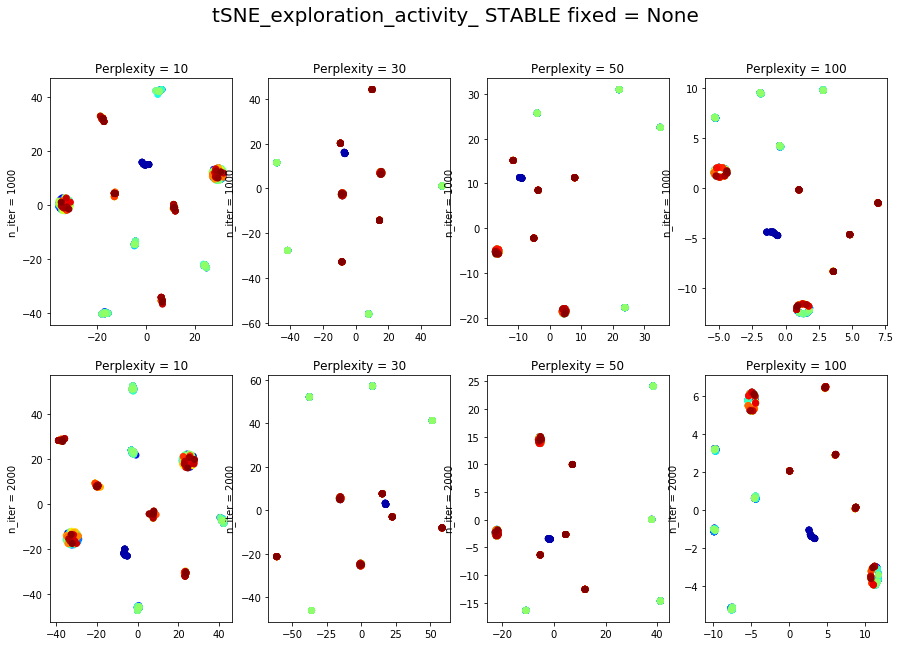

In [28]:
n_components = 2
fig = plt.figure()

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_matrix.T)
        color1 = np.linspace(0, 20, embedded.shape[0])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_activity_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_activity_parameters_time sorted'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

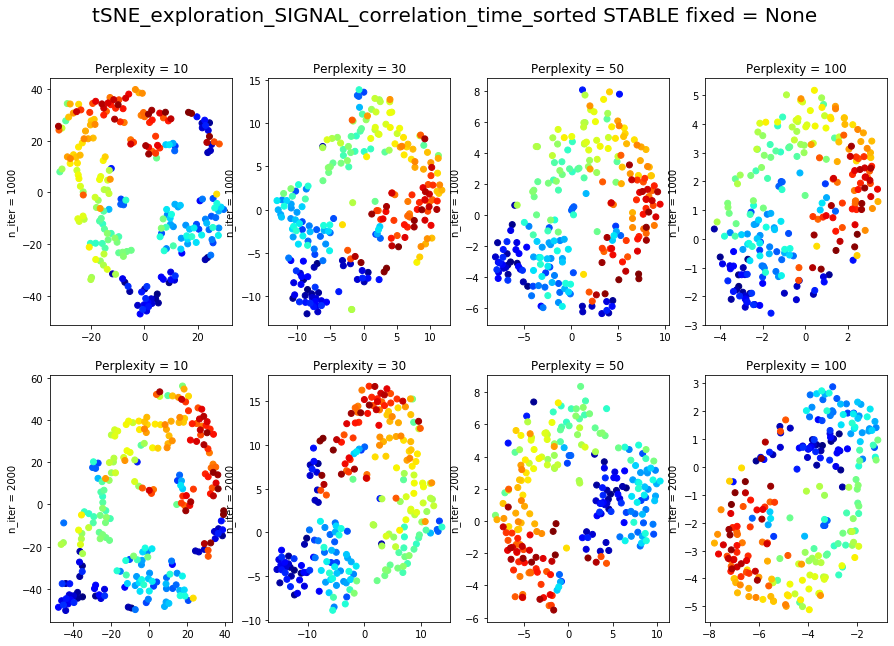

In [29]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_corr_matrix2.T)
        color1 = np.linspace(0, 20, exploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_SIGNAL_correlation_time_sorted ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_SIGNAL_correlation_parameters_time_sorted'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

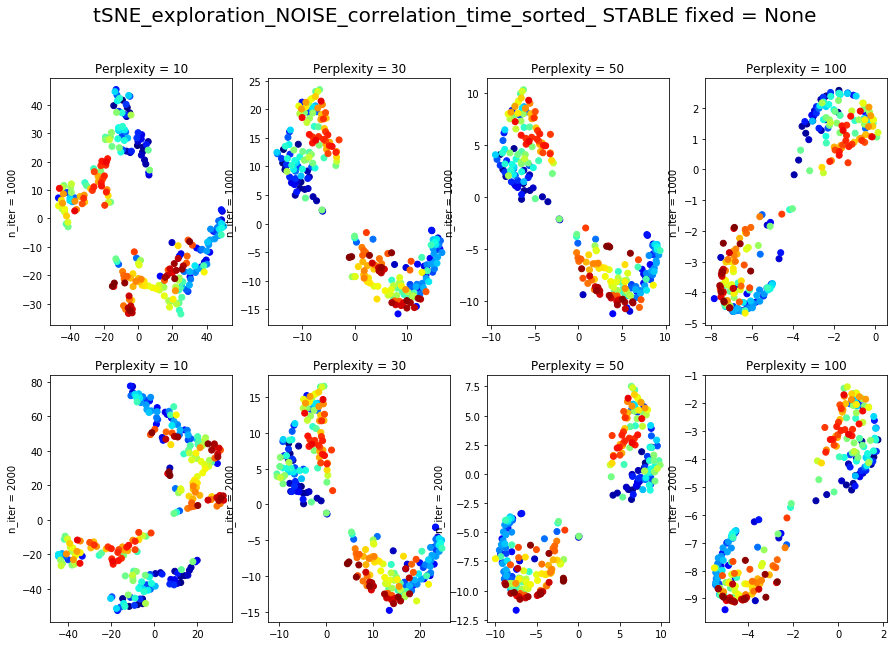

In [30]:
n_components = 2

n_iter = [1000,2000]
perplexity = [10,30,50,100]
fig = plt.figure()
gs = plt.GridSpec(2, 4)

for i in range(4):
    for j in range(2):
        embedded = TSNE(n_components=n_components, perplexity=perplexity[i], n_iter=n_iter[j]).fit_transform(exploring_corr_matrix.T)
        color1 = np.linspace(0, 20, exploring_corr_matrix.shape[1])
        ax = fig.add_subplot(gs[j, i])
        ax.scatter(embedded[:,0],embedded[:,1], c=color1, cmap=cmap)
        ax.set_title('Perplexity = ' + f'{perplexity[i]}')
        ax.set_ylabel('n_iter = ' + f'{n_iter[j]}')

fig.set_size_inches(15,10)

fig.suptitle('tSNE_exploration_NOISE_correlation_time_sorted_ ' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path + 'tSNE_exploration_NOISE_correlation_parameters_time_sorted_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)